In [1]:
import bz2
from tqdm import tqdm
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix,classification_report
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SpatialDropout1D,Embedding
from keras.callbacks import ModelCheckpoint
import pickle

/usr/local/lib/python3.10/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Loading the Dataset

In [2]:
output_path='/kaggle/working/train.ft.txt'
with bz2.open('/kaggle/input/amazonreviews/train.ft.txt.bz2', 'rt', encoding='utf-8') as compressed_file, open(output_path, 'w', encoding='utf-8') as output_file:
    for line in compressed_file:
        output_file.write(line)
    print('Train is loaded')
output_path='/kaggle/working/test.ft.txt'
with bz2.open('/kaggle/input/amazonreviews/test.ft.txt.bz2', 'rt', encoding='utf-8') as compressed_file, open(output_path, 'w', encoding='utf-8') as output_file:
    for line in compressed_file:
        output_file.write(line)
    print('Test is loaded')

Train is loaded
Test is loaded


In [3]:
train,test,train_label,test_label=[],[],[],[]
with open('train.ft.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
for line in tqdm(lines):
    train.append(line.split('__label__')[1][1:])
    train_label.append(line.split('__label__')[1][0])
with open('test.ft.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
for line in tqdm(lines):
    test.append(line.split('__label__')[1][1:])
    test_label.append(line.split('__label__')[1][0])

100%|██████████| 400000/400000 [00:00<00:00, 727056.58it/s]


# Data Cleaning and Processing

In [4]:
def clean_text(text):
    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert the text to lowercase
    text = text.lower()
    return text

In [5]:
train=pd.DataFrame(train)[0].apply(clean_text)
test=pd.DataFrame(test)[0].apply(clean_text)
train.head()

0     stuning even for the nongamer this sound trac...
1     the best soundtrack ever to anything im readi...
2     amazing this soundtrack is my favorite music ...
3     excellent soundtrack i truly like this soundt...
4     remember pull your jaw off the floor after he...
Name: 0, dtype: object

In [6]:
train_lab=np.array([1 if i=='2' else 0 for i in train_label])
test_lab=np.array([1 if i=='2' else 0 for i in test_label])

In [7]:
print('Train Length',len(train))
print('Train Label Length',len(train_label))
print('Test Length',len(test))
print('Test Label Length',len(test_label))

Train Length 3600000
Train Label Length 3600000
Test Length 400000
Test Label Length 400000


In [8]:
unique_values, counts = np.unique(train_lab, return_counts=True)
for value, count in zip(unique_values, counts): 
    print(f"Value {value}: {count} times")

print("as shown here the dataset is balanced")

Value 0: 1800000 times
Value 1: 1800000 times
as shown here the dataset is balanced


In [9]:
unique_values, counts = np.unique(test_lab, return_counts=True)
for value, count in zip(unique_values, counts): 
    print(f"Value {value}: {count} times")

print("as shown here the dataset is balanced")

Value 0: 200000 times
Value 1: 200000 times
as shown here the dataset is balanced


# Data Visualization

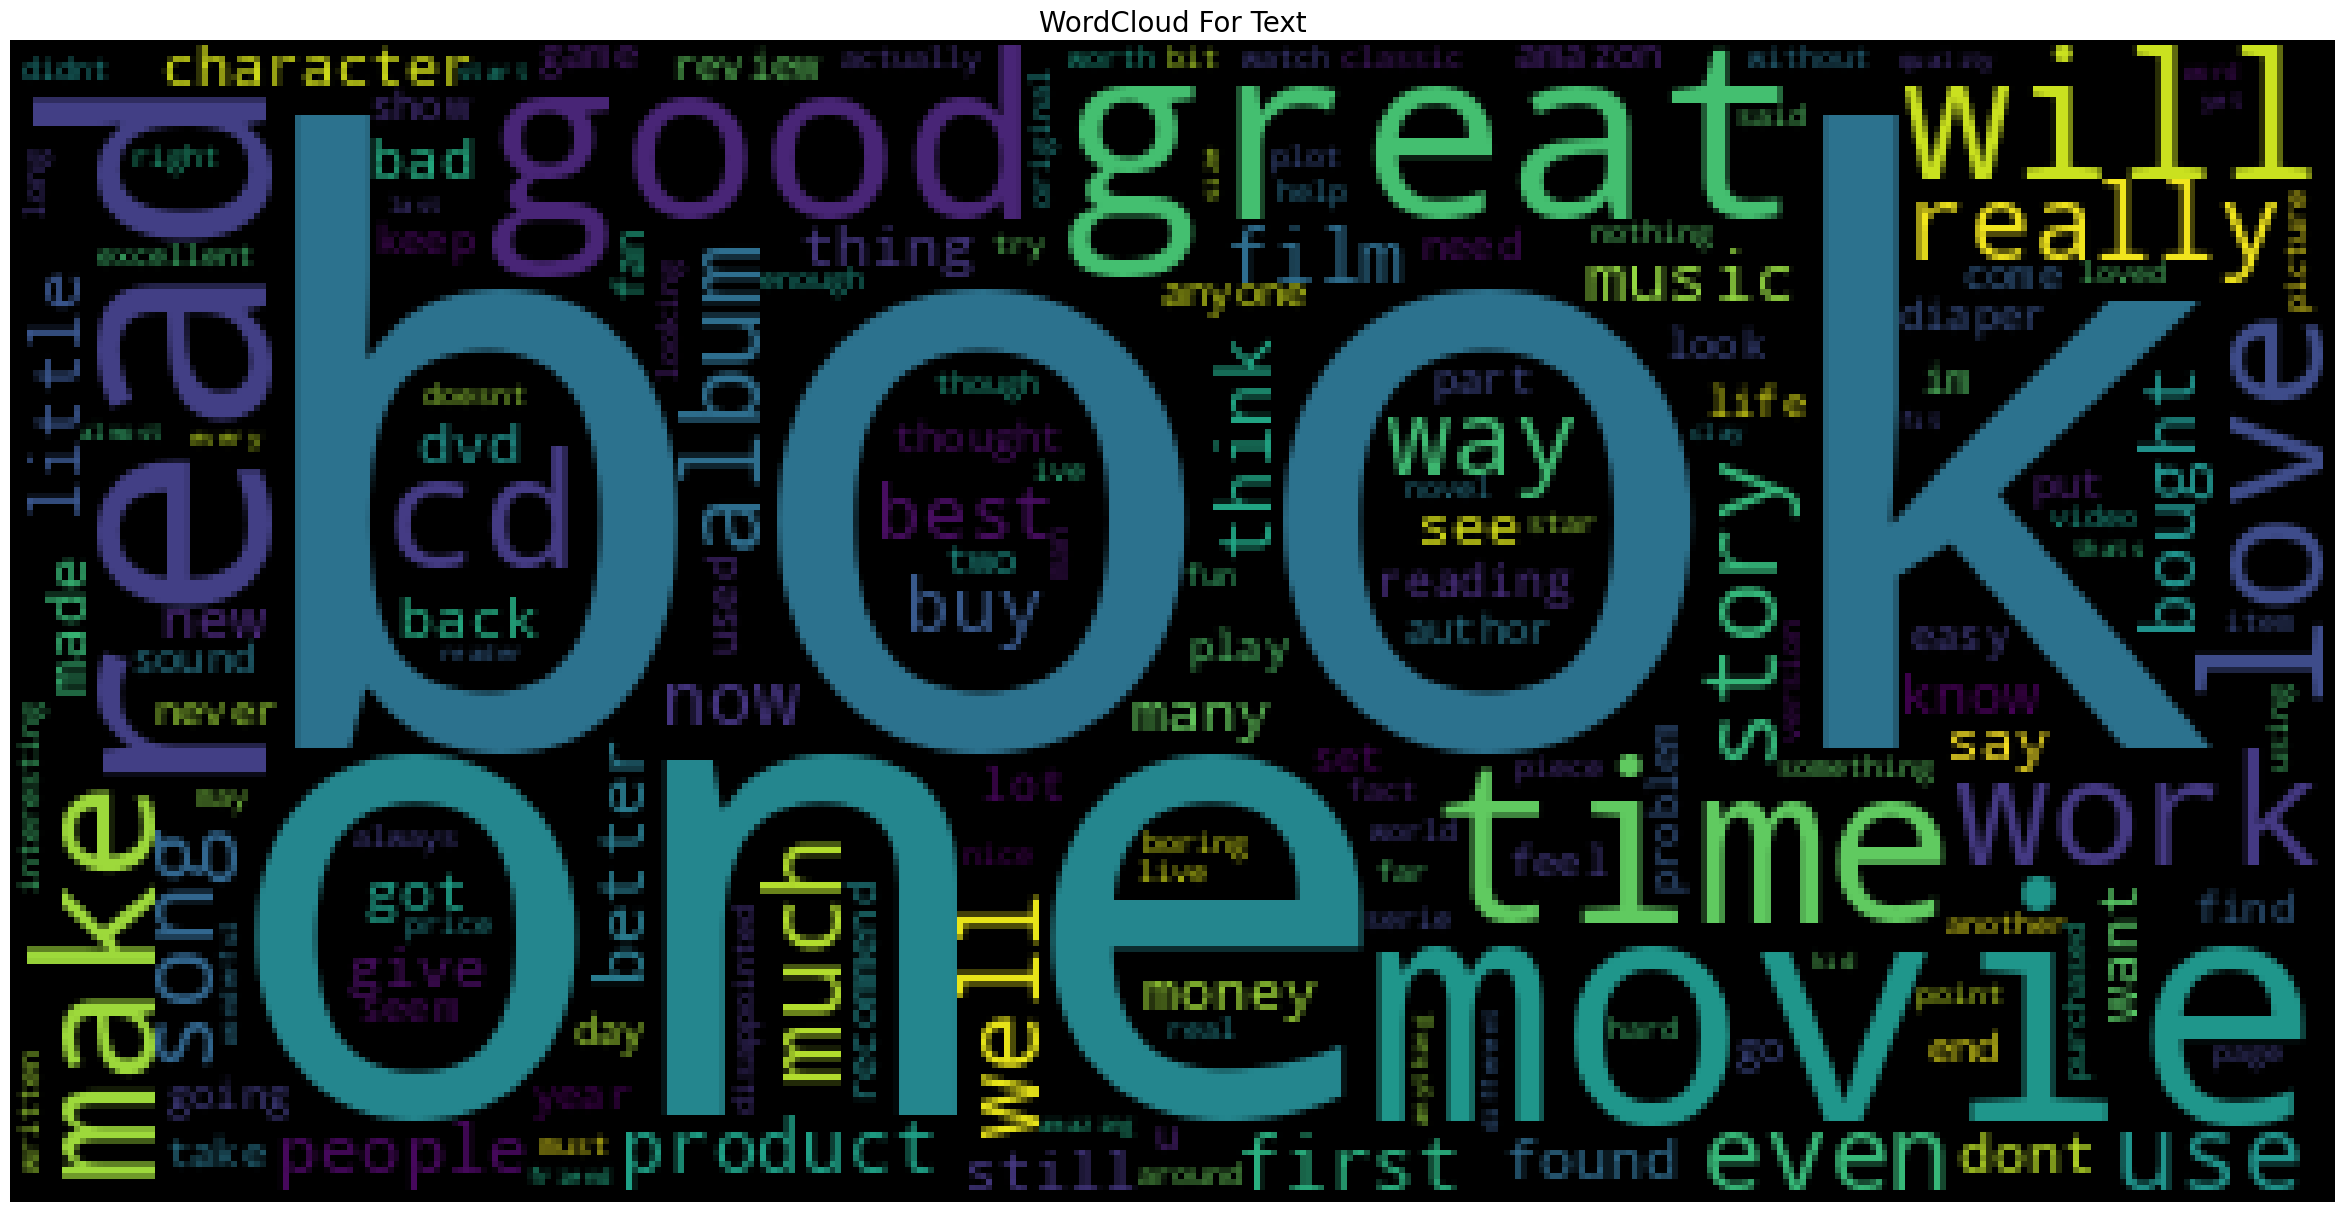

In [10]:
plt.figure(figsize=(30,20))
plt.imshow(WordCloud().generate(" ".join(train.iloc[:20000])))
plt.axis("off")
plt.title("WordCloud For Text",fontsize=20)
plt.show()

# Tokeniztion and pad_sequences

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import pickle

voc_size = 20000
max_length = 100

# Tokenization and vocabulary creation
def build_vocab(texts, vocab_size):
    counter = Counter()
    for text in texts:
        tokens = text.lower().split()  # Simple tokenization (split by spaces)
        counter.update(tokens)
    vocab = {word: idx + 1 for idx, (word, _) in enumerate(counter.most_common(vocab_size))}  # +1 for padding index 0
    return vocab

vocab = build_vocab(train, voc_size)

# Save vocabulary
with open('/kaggle/working/vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

In [12]:
# Convert texts to sequences of indices
def text_to_sequence(texts, vocab, max_length):
    sequences = []
    for text in texts:
        tokens = text.lower().split()
        sequence = [vocab.get(token, 0) for token in tokens]  # 0 for out-of-vocabulary tokens
        sequences.append(sequence)
    return sequences

train_sequences = text_to_sequence(train, vocab, max_length)
test_sequences = text_to_sequence(test, vocab, max_length)

In [13]:
def pad_sequences(sequences, max_length, pad_value=0):
    padded = []
    for seq in sequences:
        if len(seq) < max_length:
            padded_seq = seq + [pad_value] * (max_length - len(seq))  # Pad with zeros
        else:
            padded_seq = seq[:max_length]  # Truncate if longer than max_length
        padded.append(padded_seq)
    return padded

train_padded = pad_sequences(train_sequences, max_length)
test_padded = pad_sequences(test_sequences, max_length)

# Training

In [14]:
# Convert to PyTorch tensors
train_tensor = torch.tensor(train_padded, dtype=torch.long)
test_tensor = torch.tensor(test_padded, dtype=torch.long)

train_lab_tensor = torch.tensor(train_lab, dtype=torch.float)
test_lab_tensor = torch.tensor(test_lab, dtype=torch.float)


from torch.utils.data import DataLoader, Dataset
batch_size = 64

class TextDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = TextDataset(train_tensor, train_lab_tensor)
test_dataset = TextDataset(test_tensor, test_lab_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import sys

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
# Define the PyTorch model
class LSTMModel(nn.Module):
    def __init__(self, voc_size, embed_dim, hidden_dim, max_length):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=voc_size + 1, embedding_dim=embed_dim)
        self.lstm1 = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.lstm2 = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_dim, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = self.fc(x[:, -1, :])  # Use the last time step
        x = self.sigmoid(x)
        return x


# Initialize the model, loss, and optimizer

embed_dim = 64
hidden_dim = 32
batch_size = 64
epochs = 6
learning_rate = 0.001
model = LSTMModel(voc_size=voc_size, embed_dim=embed_dim, hidden_dim=hidden_dim, max_length=max_length).to(device)
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
# Training loop with accuracy tracking

# Directory to save models
import os

save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0
    
    for batch_idx, (batch_texts, batch_labels) in enumerate(train_loader, 1):
        batch_texts, batch_labels = batch_texts.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_texts)
        loss = criterion(outputs.squeeze(), batch_labels)
        loss.backward()
        optimizer.step()
        
        # Calculate batch accuracy
        predicted = (outputs.squeeze() > 0.5).float()
        epoch_correct += (predicted == batch_labels).sum().item()
        epoch_total += batch_labels.size(0)
        epoch_loss += loss.item()
        
        # # Print batch progress
        # sys.stdout.write(f"\r  Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}, Accuracy: {epoch_correct / epoch_total:.4f}")
        # sys.stdout.flush()
    
    # Compute average loss and accuracy for the epoch
    avg_loss = epoch_loss / len(train_loader)
    accuracy = epoch_correct / epoch_total
    print(f"\nEpoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


    # Save model for each epoch
    model_path = os.path.join(save_dir, f"model_epoch_{epoch + 1}_loss{avg_loss:.2f}_accuracy{accuracy:.2f}_.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved: {model_path}")


Epoch 1/6, Loss: 0.1151, Accuracy: 0.9585
Model saved: saved_models/model_epoch_1_loss0.12_accuracy0.96_.pth

Epoch 2/6, Loss: 0.1119, Accuracy: 0.9599
Model saved: saved_models/model_epoch_2_loss0.11_accuracy0.96_.pth

Epoch 3/6, Loss: 0.1093, Accuracy: 0.9610
Model saved: saved_models/model_epoch_3_loss0.11_accuracy0.96_.pth

Epoch 4/6, Loss: 0.1071, Accuracy: 0.9620
Model saved: saved_models/model_epoch_4_loss0.11_accuracy0.96_.pth

Epoch 5/6, Loss: 0.1050, Accuracy: 0.9629
Model saved: saved_models/model_epoch_5_loss0.11_accuracy0.96_.pth

Epoch 6/6, Loss: 0.1033, Accuracy: 0.9636
Model saved: saved_models/model_epoch_6_loss0.10_accuracy0.96_.pth


# Testing

In [21]:
# Evaluation
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():  # Disable gradient computation
    for batch_texts, batch_labels in test_loader:
        batch_texts, batch_labels = batch_texts.to(device), batch_labels.to(device)
        
        # Forward pass
        outputs = model(batch_texts)
        loss = criterion(outputs.squeeze(), batch_labels)
        
        # Accumulate loss
        test_loss += loss.item()
        
        # Calculate accuracy
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == batch_labels).sum().item()
        test_total += batch_labels.size(0)

# Compute average loss and accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / test_total

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.1489, Test Accuracy: 0.9461


In [31]:
!ls -lh

total 1.7G
drwxr-xr-x 2 root root 4.0K Feb  3 07:19 saved_models
-rw-r--r-- 1 root root 170M Feb  3 06:20 test.ft.txt
-rw-r--r-- 1 root root 1.5G Feb  3 06:20 train.ft.txt
-rw-r--r-- 1 root root 252K Feb  3 06:23 vocab.pkl


In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

# Upload the Weight

In [32]:

model = LSTMModel(voc_size=20000, embed_dim=64, hidden_dim=32, max_length=100)
model.load_state_dict(torch.load('saved_models/model_epoch_6_loss0.10_accuracy0.96_.pth', map_location=device, weights_only=True))
model.to(device)
model.eval()

LSTMModel(
  (embedding): Embedding(20001, 64)
  (lstm1): LSTM(64, 32, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(32, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [34]:
sample_text = ["it is not wonderful experience using the product"]

# Load the saved vocabulary
with open('/kaggle/working/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

sequence = text_to_sequence(sample_text, vocab, max_length)
sequence_padded = pad_sequences(sequence, 100)
sequence_tensor = torch.tensor(sequence_padded, dtype=torch.long).to(device)

with torch.no_grad():
    output = model(sequence_tensor)
    print("Probability:", output.item())
    print("Label:", "Positive" if output.item() >= 0.5 else "Negative")

Probability: 0.04896260052919388
Label: Negative
